In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools



In [2]:
# # URL of the white wine dataset
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

# # load the dataset from the URL
white_df = pd.read_csv(URL, sep=";")

# # fill the `is_red` column with zeros.
white_df["is_red"] = 0

# # keep only the first of duplicate items
white_df = white_df.drop_duplicates(keep='first')

In [3]:
print(white_df.alcohol[0])
print(white_df.alcohol[100])

8.8
9.1


In [4]:
# # URL of the red wine dataset
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'

# # load the dataset from the URL
red_df = pd.read_csv(URL, sep=";")

# # fill the `is_red` column with ones.
red_df["is_red"] = 1

# # keep only the first of duplicate items
red_df = red_df.drop_duplicates(keep='first')

In [5]:
print(red_df.alcohol[0])
print(red_df.alcohol[100])

9.4
10.2


In [6]:
df = pd.concat([red_df, white_df], ignore_index=True)

In [7]:
print(df.alcohol[0])
print(df.alcohol[100])

9.4
9.5


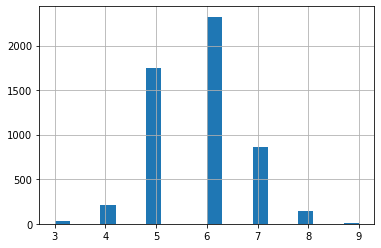

In [8]:
df['quality'].hist(bins=20);

In [9]:
# # get data with wine quality greater than 4 and less than 8
df = df[(df['quality'] > 4) & (df['quality'] < 8 )]

# # reset index and drop the old one
df = df.reset_index(drop=True)

In [10]:
print(df.alcohol[0])
print(df.alcohol[100])

9.4
10.9


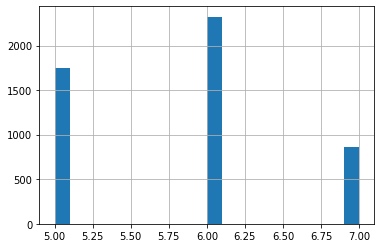

In [11]:
df['quality'].hist(bins=20);

In [12]:
# # split df into 80:20 train and test sets
train, test = train_test_split(df, test_size=0.2, random_state = 1)
                               
# # split train into 80:20 train and val sets
train, val = train_test_split(train, test_size= 0.2, random_state = 1)

In [13]:
train_stats = train.describe()
train_stats.pop('is_red')
train_stats.pop('quality')
train_stats = train_stats.transpose()

In [14]:
train_stats

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3155.0,7.221616,1.325297,3.80000,6.40000,7.00000,7.7000,15.60000
volatile acidity,3155.0,0.338929,0.162476,0.08000,0.23000,0.29000,0.4000,1.24000
citric acid,3155.0,0.321569,0.147970,0.00000,0.25000,0.31000,0.4000,1.66000
residual sugar,3155.0,5.155911,4.639632,0.60000,1.80000,2.80000,7.6500,65.80000
chlorides,3155.0,0.056976,0.036802,0.01200,0.03800,0.04700,0.0660,0.61100
free sulfur dioxide,3155.0,30.388590,17.236784,1.00000,17.00000,28.00000,41.0000,131.00000
total sulfur dioxide,3155.0,115.062282,56.706617,6.00000,75.00000,117.00000,156.0000,344.00000
density,3155.0,0.994633,0.003005,0.98711,0.99232,0.99481,0.9968,1.03898
pH,3155.0,3.223201,0.161272,2.72000,3.11000,3.21000,3.3300,4.01000
sulphates,3155.0,0.534051,0.149149,0.22000,0.43000,0.51000,0.6000,1.95000


In [15]:
def format_output(data):
    is_red = data.pop('is_red')
    is_red = np.array(is_red)
    quality = data.pop('quality')
    quality = np.array(quality)
    return (quality, is_red)

In [16]:
# # format the output of the train set
train_Y = format_output(train)

# # format the output of the val set
val_Y = format_output(val)
    
# # format the output of the test set
test_Y = format_output(test)

In [17]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
225,7.5,0.65,0.18,7.0,0.088,27.0,94.0,0.99915,3.38,0.77,9.4
3557,6.3,0.27,0.29,12.2,0.044,59.0,196.0,0.99782,3.14,0.40,8.8
3825,8.8,0.27,0.25,5.0,0.024,52.0,99.0,0.99250,2.87,0.49,11.4
1740,6.4,0.45,0.07,1.1,0.030,10.0,131.0,0.99050,2.97,0.28,10.8
1221,7.2,0.53,0.13,2.0,0.058,18.0,22.0,0.99573,3.21,0.68,9.9


In [18]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [19]:
# # normalize the train set
norm_train_X = norm(train)
    
# # normalize the val set
norm_val_X = norm(val)
    
# # normalize the test set
norm_test_X = norm(test)

In [20]:
def base_model(inputs):
    
    
#     # connect a Dense layer with 128 neurons and a relu activation
    x = tf.keras.layers.Dense('128', activation = 'relu')(inputs)
    
#     # connect another Dense layer with 128 neurons and a relu activation
    x = tf.keras.layers.Dense('128', activation = 'relu')(x)
    return x

In [21]:
def final_model(inputs):
    
#     # get the base model
    x = base_model(inputs)

#     # connect the output Dense layer for regression
    wine_quality = Dense(units='1', name='wine_quality')(x)

#     # connect the output Dense layer for classification. this will use a sigmoid activation.
    wine_type = Dense(units='1', activation= 'sigmoid', name='wine_type')(x)

#     # define the model using the input and output layers
    model = Model(inputs= inputs, outputs= [wine_quality, wine_type])

    return model


In [22]:
inputs = tf.keras.layers.Input(shape=(11,))
rms = tf.keras.optimizers.RMSprop(lr=0.0001)
model = final_model(inputs)

model.compile(optimizer=rms, 
              loss = {'wine_type' : 'binary_crossentropy',
                      'wine_quality' : 'mse'
                     },
              metrics = {'wine_type' : ['accuracy'],
                         'wine_quality':tf.keras.metrics.RootMeanSquaredError(),
                        }
             )

In [23]:
history = model.fit(norm_train_X, train_Y,
                    epochs = 180, validation_data=(norm_test_X, test_Y))

Epoch 1/180
99/99 [==============================] - 1s 6ms/step - loss: 27.5664 - wine_quality_loss: 26.8916 - wine_type_loss: 0.6748 - wine_quality_root_mean_squared_error: 5.1857 - wine_type_accuracy: 0.6238 - val_loss: 20.5415 - val_wine_quality_loss: 19.8899 - val_wine_type_loss: 0.6516 - val_wine_quality_root_mean_squared_error: 4.4598 - val_wine_type_accuracy: 0.7396
Epoch 2/180
99/99 [==============================] - 0s 4ms/step - loss: 14.3074 - wine_quality_loss: 13.6855 - wine_type_loss: 0.6219 - wine_quality_root_mean_squared_error: 3.6994 - wine_type_accuracy: 0.7918 - val_loss: 9.3242 - val_wine_quality_loss: 8.7387 - val_wine_type_loss: 0.5856 - val_wine_quality_root_mean_squared_error: 2.9561 - val_wine_type_accuracy: 0.8622
Epoch 3/180
99/99 [==============================] - 0s 4ms/step - loss: 5.8971 - wine_quality_loss: 5.3612 - wine_type_loss: 0.5358 - wine_quality_root_mean_squared_error: 2.3154 - wine_type_accuracy: 0.8529 - val_loss: 3.9214 - val_wine_quality_l

Epoch 23/180
99/99 [==============================] - 0s 4ms/step - loss: 0.6874 - wine_quality_loss: 0.6455 - wine_type_loss: 0.0419 - wine_quality_root_mean_squared_error: 0.8034 - wine_type_accuracy: 0.9918 - val_loss: 0.7137 - val_wine_quality_loss: 0.6717 - val_wine_type_loss: 0.0420 - val_wine_quality_root_mean_squared_error: 0.8196 - val_wine_type_accuracy: 0.9939
Epoch 24/180
99/99 [==============================] - 0s 4ms/step - loss: 0.6564 - wine_quality_loss: 0.6157 - wine_type_loss: 0.0407 - wine_quality_root_mean_squared_error: 0.7847 - wine_type_accuracy: 0.9921 - val_loss: 0.6801 - val_wine_quality_loss: 0.6391 - val_wine_type_loss: 0.0410 - val_wine_quality_root_mean_squared_error: 0.7994 - val_wine_type_accuracy: 0.9939
Epoch 25/180
99/99 [==============================] - 0s 4ms/step - loss: 0.6270 - wine_quality_loss: 0.5873 - wine_type_loss: 0.0397 - wine_quality_root_mean_squared_error: 0.7664 - wine_type_accuracy: 0.9924 - val_loss: 0.6552 - val_wine_quality_loss

Epoch 45/180
99/99 [==============================] - 0s 4ms/step - loss: 0.3759 - wine_quality_loss: 0.3451 - wine_type_loss: 0.0308 - wine_quality_root_mean_squared_error: 0.5875 - wine_type_accuracy: 0.9943 - val_loss: 0.4167 - val_wine_quality_loss: 0.3838 - val_wine_type_loss: 0.0328 - val_wine_quality_root_mean_squared_error: 0.6196 - val_wine_type_accuracy: 0.9959
Epoch 46/180
99/99 [==============================] - 0s 4ms/step - loss: 0.3720 - wine_quality_loss: 0.3414 - wine_type_loss: 0.0305 - wine_quality_root_mean_squared_error: 0.5843 - wine_type_accuracy: 0.9940 - val_loss: 0.4120 - val_wine_quality_loss: 0.3794 - val_wine_type_loss: 0.0327 - val_wine_quality_root_mean_squared_error: 0.6159 - val_wine_type_accuracy: 0.9959
Epoch 47/180
99/99 [==============================] - 0s 4ms/step - loss: 0.3675 - wine_quality_loss: 0.3372 - wine_type_loss: 0.0304 - wine_quality_root_mean_squared_error: 0.5807 - wine_type_accuracy: 0.9940 - val_loss: 0.4103 - val_wine_quality_loss

Epoch 67/180
99/99 [==============================] - 0s 4ms/step - loss: 0.3301 - wine_quality_loss: 0.3031 - wine_type_loss: 0.0270 - wine_quality_root_mean_squared_error: 0.5505 - wine_type_accuracy: 0.9952 - val_loss: 0.3760 - val_wine_quality_loss: 0.3459 - val_wine_type_loss: 0.0301 - val_wine_quality_root_mean_squared_error: 0.5881 - val_wine_type_accuracy: 0.9959
Epoch 68/180
99/99 [==============================] - 0s 4ms/step - loss: 0.3311 - wine_quality_loss: 0.3042 - wine_type_loss: 0.0269 - wine_quality_root_mean_squared_error: 0.5516 - wine_type_accuracy: 0.9952 - val_loss: 0.3754 - val_wine_quality_loss: 0.3454 - val_wine_type_loss: 0.0300 - val_wine_quality_root_mean_squared_error: 0.5877 - val_wine_type_accuracy: 0.9959
Epoch 69/180
99/99 [==============================] - 0s 4ms/step - loss: 0.3295 - wine_quality_loss: 0.3027 - wine_type_loss: 0.0268 - wine_quality_root_mean_squared_error: 0.5502 - wine_type_accuracy: 0.9952 - val_loss: 0.3758 - val_wine_quality_loss

Epoch 89/180
99/99 [==============================] - 0s 4ms/step - loss: 0.3142 - wine_quality_loss: 0.2899 - wine_type_loss: 0.0243 - wine_quality_root_mean_squared_error: 0.5384 - wine_type_accuracy: 0.9959 - val_loss: 0.3689 - val_wine_quality_loss: 0.3405 - val_wine_type_loss: 0.0284 - val_wine_quality_root_mean_squared_error: 0.5836 - val_wine_type_accuracy: 0.9970
Epoch 90/180
99/99 [==============================] - 0s 4ms/step - loss: 0.3132 - wine_quality_loss: 0.2890 - wine_type_loss: 0.0241 - wine_quality_root_mean_squared_error: 0.5376 - wine_type_accuracy: 0.9956 - val_loss: 0.3671 - val_wine_quality_loss: 0.3388 - val_wine_type_loss: 0.0283 - val_wine_quality_root_mean_squared_error: 0.5821 - val_wine_type_accuracy: 0.9970
Epoch 91/180
99/99 [==============================] - 0s 4ms/step - loss: 0.3130 - wine_quality_loss: 0.2890 - wine_type_loss: 0.0240 - wine_quality_root_mean_squared_error: 0.5376 - wine_type_accuracy: 0.9959 - val_loss: 0.3679 - val_wine_quality_loss

Epoch 111/180
99/99 [==============================] - 0s 4ms/step - loss: 0.3008 - wine_quality_loss: 0.2787 - wine_type_loss: 0.0221 - wine_quality_root_mean_squared_error: 0.5279 - wine_type_accuracy: 0.9962 - val_loss: 0.3640 - val_wine_quality_loss: 0.3368 - val_wine_type_loss: 0.0272 - val_wine_quality_root_mean_squared_error: 0.5804 - val_wine_type_accuracy: 0.9970
Epoch 112/180
99/99 [==============================] - 0s 4ms/step - loss: 0.3008 - wine_quality_loss: 0.2787 - wine_type_loss: 0.0221 - wine_quality_root_mean_squared_error: 0.5279 - wine_type_accuracy: 0.9962 - val_loss: 0.3637 - val_wine_quality_loss: 0.3366 - val_wine_type_loss: 0.0271 - val_wine_quality_root_mean_squared_error: 0.5802 - val_wine_type_accuracy: 0.9970
Epoch 113/180
99/99 [==============================] - 0s 4ms/step - loss: 0.3012 - wine_quality_loss: 0.2792 - wine_type_loss: 0.0219 - wine_quality_root_mean_squared_error: 0.5284 - wine_type_accuracy: 0.9962 - val_loss: 0.3664 - val_wine_quality_l

Epoch 133/180
99/99 [==============================] - 0s 4ms/step - loss: 0.2918 - wine_quality_loss: 0.2715 - wine_type_loss: 0.0202 - wine_quality_root_mean_squared_error: 0.5211 - wine_type_accuracy: 0.9965 - val_loss: 0.3670 - val_wine_quality_loss: 0.3410 - val_wine_type_loss: 0.0260 - val_wine_quality_root_mean_squared_error: 0.5840 - val_wine_type_accuracy: 0.9970
Epoch 134/180
99/99 [==============================] - 0s 4ms/step - loss: 0.2901 - wine_quality_loss: 0.2700 - wine_type_loss: 0.0202 - wine_quality_root_mean_squared_error: 0.5196 - wine_type_accuracy: 0.9965 - val_loss: 0.3652 - val_wine_quality_loss: 0.3392 - val_wine_type_loss: 0.0260 - val_wine_quality_root_mean_squared_error: 0.5824 - val_wine_type_accuracy: 0.9970
Epoch 135/180
99/99 [==============================] - 0s 4ms/step - loss: 0.2900 - wine_quality_loss: 0.2699 - wine_type_loss: 0.0201 - wine_quality_root_mean_squared_error: 0.5196 - wine_type_accuracy: 0.9965 - val_loss: 0.3651 - val_wine_quality_l

Epoch 155/180
99/99 [==============================] - 0s 4ms/step - loss: 0.2809 - wine_quality_loss: 0.2622 - wine_type_loss: 0.0187 - wine_quality_root_mean_squared_error: 0.5121 - wine_type_accuracy: 0.9965 - val_loss: 0.3704 - val_wine_quality_loss: 0.3452 - val_wine_type_loss: 0.0252 - val_wine_quality_root_mean_squared_error: 0.5876 - val_wine_type_accuracy: 0.9970
Epoch 156/180
99/99 [==============================] - 0s 4ms/step - loss: 0.2818 - wine_quality_loss: 0.2632 - wine_type_loss: 0.0187 - wine_quality_root_mean_squared_error: 0.5130 - wine_type_accuracy: 0.9965 - val_loss: 0.3623 - val_wine_quality_loss: 0.3371 - val_wine_type_loss: 0.0251 - val_wine_quality_root_mean_squared_error: 0.5806 - val_wine_type_accuracy: 0.9970
Epoch 157/180
99/99 [==============================] - 2s 17ms/step - loss: 0.2818 - wine_quality_loss: 0.2633 - wine_type_loss: 0.0186 - wine_quality_root_mean_squared_error: 0.5131 - wine_type_accuracy: 0.9965 - val_loss: 0.3566 - val_wine_quality_

Epoch 177/180
99/99 [==============================] - 0s 4ms/step - loss: 0.2736 - wine_quality_loss: 0.2562 - wine_type_loss: 0.0174 - wine_quality_root_mean_squared_error: 0.5061 - wine_type_accuracy: 0.9965 - val_loss: 0.3650 - val_wine_quality_loss: 0.3406 - val_wine_type_loss: 0.0243 - val_wine_quality_root_mean_squared_error: 0.5836 - val_wine_type_accuracy: 0.9970
Epoch 178/180
99/99 [==============================] - 0s 4ms/step - loss: 0.2738 - wine_quality_loss: 0.2565 - wine_type_loss: 0.0173 - wine_quality_root_mean_squared_error: 0.5065 - wine_type_accuracy: 0.9968 - val_loss: 0.3582 - val_wine_quality_loss: 0.3340 - val_wine_type_loss: 0.0243 - val_wine_quality_root_mean_squared_error: 0.5779 - val_wine_type_accuracy: 0.9970
Epoch 179/180
99/99 [==============================] - 0s 4ms/step - loss: 0.2738 - wine_quality_loss: 0.2566 - wine_type_loss: 0.0172 - wine_quality_root_mean_squared_error: 0.5065 - wine_type_accuracy: 0.9968 - val_loss: 0.3589 - val_wine_quality_l

In [24]:
# Gather the training metrics
loss, wine_quality_loss, wine_type_loss, wine_quality_rmse, wine_type_accuracy = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'loss: {loss}')
print(f'wine_quality_loss: {wine_quality_loss}')
print(f'wine_type_loss: {wine_type_loss}')
print(f'wine_quality_rmse: {wine_quality_rmse}')
print(f'wine_type_accuracy: {wine_type_accuracy}')

25/25 [==============================] - 0s 2ms/step - loss: 0.3468 - wine_quality_loss: 0.3182 - wine_type_loss: 0.0286 - wine_quality_root_mean_squared_error: 0.5641 - wine_type_accuracy: 0.9937

loss: 0.3467765152454376
wine_quality_loss: 0.318202942609787
wine_type_loss: 0.02857358567416668
wine_quality_rmse: 0.5640947818756104
wine_type_accuracy: 0.9936628937721252


In [25]:
predictions = model.predict(norm_test_X)
quality_pred = predictions[0]
type_pred = predictions[1]

In [26]:
print(quality_pred[0])

[5.693209]


In [27]:
print(type_pred[0])
print(type_pred[944])

[8.795014e-05]
[0.9999788]


In [28]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [29]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

In [30]:
def plot_diff(y_true, y_pred, title = '' ):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.plot([-100, 100], [-100, 100])
    return plt

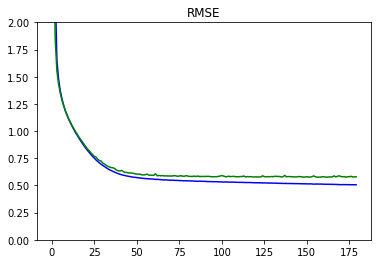

In [31]:
plot_metrics('wine_quality_root_mean_squared_error', 'RMSE', ylim=2)

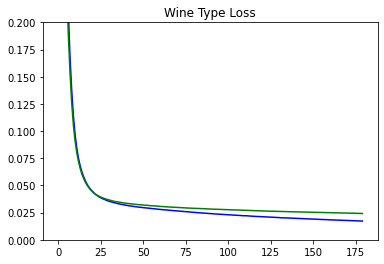

In [32]:
plot_metrics('wine_type_loss', 'Wine Type Loss', ylim=0.2)

<ipython-input-29-47bb6e202cb0>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-29-47bb6e202cb0>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


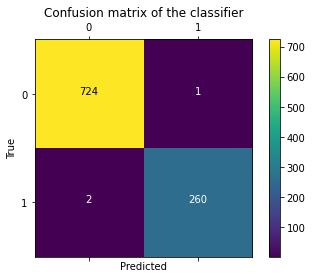

In [33]:
plot_confusion_matrix(test_Y[1], np.round(type_pred), title='Wine Type', labels = [0, 1])

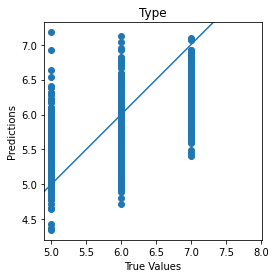

In [34]:

scatter_plot = plot_diff(test_Y[0], quality_pred, title='Type')